<a href="https://colab.research.google.com/github/maryamhashemi/Persian_VQA/blob/master/rez_PVQA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Prerequesties

In [24]:
! pip install arabic_reshaper 
! pip install python-bidi
!pip install deepdish
!pip install --upgrade numpy
!pip install --upgrade tables

Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.19.1)
Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.6.1)


In [5]:
import os,h5py
import re
import json
import numpy as np
import deepdish as dd
from PIL import Image
import arabic_reshaper
from collections import Counter
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Multiply, Input

import random as python_random
import tensorflow as tf
import math
from tensorflow.keras.callbacks import EarlyStopping 
import tensorflow as tf

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Set Parameters

In [6]:
DROPOUT_RATE = 0.5
EMBEDDING_DIM = 300
EPOCHS = 10
BATCH_SIZE = 256
SEQ_LENGTH = 26 #100
VOCAB_SIZE = 1000
OOV_TOK = "<OOV>"

BASE_PATH = '/content/drive/My Drive/Persian_VQA/dataset/'
QUESTION_TRAIN_PATH =   os.path.join(BASE_PATH, 'OpenEnded_mscoco_train2014_questions.json')
ANNOTATION_TRAIN_PATH = os.path.join(BASE_PATH, 'mscoco_train2014_annotations.json')
# IMAGE_TRAIN_PATH = os.path.join(BASE_PATH, 'train_images_1000')
IMAGE_TRAIN_PATH = os.path.join('/content/', 'train')

QUESTION_VAL_PATH =   os.path.join(BASE_PATH, 'OpenEnded_mscoco_val2014_questions.json')
ANNOTATION_VAL_PATH = os.path.join(BASE_PATH, 'mscoco_val2014_annotations.json')
# IMAGE_VAL_PATH = os.path.join(BASE_PATH, 'val_images_500')
IMAGE_VAL_PATH = os.path.join('/content/', 'val')

QUESTION_TEST_PATH =   os.path.join(BASE_PATH, '...')
ANNOTATION_TEST_PATH = os.path.join(BASE_PATH, '...')
# IMAGE_TEST_PATH = os.path.join(BASE_PATH, 'val_images_500')
IMAGE_TEST_PATH = os.path.join('/content/', 'test')

NUM_OF_CLASSES=1000
NUM_OF_MOST_COMMON_ANSWERS = 999
BASE_PATH_parssoft = '/content/drive/My Drive/parssoftco_PVQA/'
BASE_PATH_parssoft2 = '/content/drive/My Drive/parssoftco_PVQA2/'

In [7]:
# import os
from zipfile import ZipFile
# #If the downloaded file is a zip file than you can use below function to unzip it.
def unzip(dir,where):
    with ZipFile(dir) as zipf:
        zipf.extractall(where)
    print("File Unzipped!")

In [ ]:
!wget https://filebox.ece.vt.edu/~jiasenlu/codeRelease/vqaRelease/train_only/data_train_val.zip

--2020-08-03 00:51:52--  https://filebox.ece.vt.edu/~jiasenlu/codeRelease/vqaRelease/train_only/data_train_val.zip
Resolving filebox.ece.vt.edu (filebox.ece.vt.edu)... 128.173.88.43
Connecting to filebox.ece.vt.edu (filebox.ece.vt.edu)|128.173.88.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 716074236 (683M) [application/zip]
Saving to: ‘data_train_val.zip’

data_train_val.zip  100%[===================>] 682.90M  23.9MB/s    in 29s     

2020-08-03 00:52:22 (23.2 MB/s) - ‘data_train_val.zip’ saved [716074236/716074236]



In [ ]:
unzip('/content/data_train_val.zip',BASE_PATH_parssoft)#drive/My Drive/Persian_VQA/
#data_img.h5 data_prepro.h5 data_prepro.json

File Unzipped!


### Read Data

In [8]:
def most_common_answer_from_train(answers,num_of_common_answers):
  counts = {}
  for ans in answers:
      counts[ans] = counts.get(ans,0) + 1
  counter = sorted([(count,w) for w,count in counts.items()], reverse=True)
  most_common_vocab = []
  for i in range(num_of_common_answers):
      most_common_vocab.append(counter[i][1])
  return most_common_vocab

In [9]:
def create_train_dataset(qus, ann, answertoindex):
  qs = []
  # raw_answers = []
  answers = []
  qs_id = []
  im_id = []

  # ann2=ann
  # for ann in ann['annotations']:
  #   raw_answers.append(ann['multiple_choice_answer'])
  # most_common_answers = most_common_answer_from_train(raw_answers,NUM_OF_MOST_COMMON_ANSWERS)
  # answertoindex = {w:i+1 for i,w in enumerate(most_common_answers)}
  # indextoanswer = {i+1:w for i,w in enumerate(most_common_answers)}

  filtered_train_question_ids={}
  # ann=ann2





  i=0
  for ann in ann['annotations']:
 
    if ann['multiple_choice_answer'] in answertoindex.keys():
      answers.append(ann['multiple_choice_answer'])
      # filtered_train_question_ids.append(ann['question_id'])
      filtered_train_question_ids[ann['question_id']]=1
      # if(i%1000==0):print(i)
      i+=1

  for q in qus['questions']:
    if q['question_id'] in filtered_train_question_ids.keys():
      qs.append(q['question'])
      qs_id.append(q['question_id'])
      im_id.append(q['image_id'])


  return qs, answers, qs_id, im_id

In [10]:
def create_dataset(qus, ann):
  qs = []
  raw_answers = []
  answers = []
  qs_id = []
  im_id = []
 

  for q in qus['questions']:
    qs.append(q['question'])
    qs_id.append(q['question_id'])
    im_id.append(q['image_id'])

  for ann in ann['annotations']:
    answers.append(ann['multiple_choice_answer'])


  return qs, answers, qs_id, im_id

In [11]:
def get_train_dataset():
  qs = json.load( open(QUESTION_TRAIN_PATH))
  ann = json.load( open(ANNOTATION_TRAIN_PATH))

  original_ann = ann
  raw_answers = []
  for ann in ann['annotations']:
    raw_answers.append(ann['multiple_choice_answer'])
  most_common_answers = most_common_answer_from_train(raw_answers,NUM_OF_MOST_COMMON_ANSWERS)
  answertoindex = {w:i for i,w in enumerate(most_common_answers)}#i+1
  indextoanswer = {i:w for i,w in enumerate(most_common_answers)}#i+1

  qs, answers, qs_id, im_id=create_train_dataset(qs, original_ann, answertoindex)

  return qs, answers, qs_id, im_id,answertoindex,indextoanswer

In [12]:
def get_val_dataset():
  qs = json.load( open(QUESTION_VAL_PATH))
  ann = json.load( open(ANNOTATION_VAL_PATH))
  
  return create_dataset(qs, ann)

In [13]:
def get_test_dataset():
  qs = json.load( open(QUESTION_TEST_PATH))
  # ann = json.load( open(ANNOTATION_TRAIN_PATH))
  
  return create_dataset(ims, qs)

#### Visualize Data

In [14]:
def show_visualqa(qs, answer, image):
  im = Image.open(image)  
  plt.figure()
  plt.imshow(im)
  title = arabic_reshaper.reshape(qs + "\n" + answer)
  title = get_display(title) 
  plt.title(title)
  plt.axis('off')
  plt.show()

def visualize_train(num):
  show_visualqa(train_qs[num], train_answers[num], ims.get(train_image_ids[num]))

In [15]:
train_qs, train_answers, train_q_ids, train_image_ids, answertoindex, indextoanswer = get_train_dataset()
val_qs, val_answers, val_q_ids, val_image_ids = get_val_dataset()
# test_qs, test_answers, test_q_ids, test_image_ids = get_test_dataset()

print('train : ')
print(len(train_qs))
print(len(train_answers))
print(len(train_q_ids))
print(len(train_image_ids))

print('val : ')
print(len(val_qs))
print(len(val_answers))
print(len(val_q_ids))
print(len(val_image_ids))

# print(len(test_qs))
# print(len(test_answers))
# print(len(test_q_ids))
# print(len(test_image_ids))

#train : 215359   val: 121512
#train : 215375   val: 121512 ours

train : 
215359
215359
215359
215359
val : 
121512
121512
121512
121512


In [16]:
train_answers.count('business')

0

In [ ]:
val_answers

In [16]:
li=[]
for t in train_qs:
  li.append(len(t))
question_max_len=np.max(li)
print(question_max_len)

100


In [ ]:
# ims = get_train_image_paths()
# visualize_train(0)
# visualize_train(2200)
# visualize_train(600)

#### Prepare questions to feed into network

In [ ]:
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip


--2020-08-01 00:01:12--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.16MB/s    in 6m 26s  

2020-08-01 00:07:38 (2.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
# !unzip /content/glove.6B.zip
unzip('/content/glove.6B.zip','/content/drive/My Drive/parssoftco_PVQA/')

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
File Unzipped!


In [ ]:
from urllib.request import urlopen
import gzip

vocab_and_vectors = {}
file = open(BASE_PATH_parssoft+'glove.6B.300d.txt')
for line in (file):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    vocab_and_vectors[word] = coef



In [ ]:
from urllib.request import urlopen
import gzip

# get the vectors
file = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ro.300.vec.gz'))
# https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.bin.gz
# Now let’s prepare this file for vector extraction.

vocab_and_vectors = {}
# put words as dict indexes and vectors as words values
for line in file:
  values = line.split()
  word = values [0].decode('utf-8')
  vector = np.asarray(values[1:], dtype='float32')
  vocab_and_vectors[word] = vector

In [ ]:
dd.io.save(BASE_PATH_parssoft +'fasttext-en-300.h5', vocab_and_vectors)

In [ ]:
#persian fasttext
from urllib.request import urlopen
import gzip

# get the vectors
file_fa = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.vec.gz'))
# https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.bin.gz
# Now let’s prepare this file for vector extraction.



# import codecs
# f = codecs.open('unicode.rst', encoding='utf-8')
# for line in f:
#     print (repr(line))

vocab_and_vectors_fa = {}
# put words as dict indexes and vectors as words values
for line in file_fa:
  values = line.split()
  # print(values)
  word = values [0].decode('utf-8')
  vector = np.asarray(values[1:], dtype='float32')
  vocab_and_vectors_fa[word] = vector


In [ ]:
# num_words = VOCAB_SIZE,

# !"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n
tokenizer = Tokenizer(oov_token=OOV_TOK)#filters="-.\"',:? !\$#@~()*&\^%;\[\]/\\\+<>\n="
tokenizer.fit_on_texts(train_qs)

train_X_seqs = tokenizer.texts_to_sequences(train_qs)
val_X_seqs = tokenizer.texts_to_sequences(val_qs)
# test_X_seqs = tokenizer.texts_to_sequences(test_qs)

train_X_seqs = pad_sequences(train_X_seqs, maxlen=SEQ_LENGTH, padding='pre')#post
val_X_seqs = pad_sequences(val_X_seqs, maxlen=SEQ_LENGTH, padding='pre')#post
# test_X_seqs = pad_sequences(test_X_seqs, maxlen=SEQ_LENGTH, padding='post')

train_X_seqs = np.array(train_X_seqs)
val_X_seqs = np.array(val_X_seqs)
# test_X_seqs = np.array(test_X_seqs)


word_index = tokenizer.word_index

In [ ]:
# train_X_seqs = [word_tokenize(i) for i in train_qs]
# val_X_seqs = [word_tokenize(i) for i in val_qs]

# all_words = []
# for sent in train_qs:
#     tokenize_word = word_tokenize(sent)
#     for word in tokenize_word:
#         all_words.append(word)
# from keras.preprocessing.text import one_hot
# embedded_sentences = [one_hot(sent, 13447) for sent in train_qs]
# print(embedded_sentences[0] )

In [43]:
def right_align(seq,lengths):
    v = np.zeros(np.shape(seq))
    N = np.shape(seq)[1]
    for i in range(np.shape(seq)[0]):
        v[i][N-lengths[i]:N]=seq[i][0:lengths[i]]
    return v

In [2]:
ques_data = h5py.File(BASE_PATH_parssoft + 'data_prepro.h5')
ques_answers = np.array(ques_data['answers'])[:]



NameError: ignored

In [1]:
ques_answers.shape

NameError: ignored

In [59]:
qss_train = json.load( open(QUESTION_TRAIN_PATH))
qss_val = json.load( open(QUESTION_VAL_PATH))
ques_data = h5py.File(BASE_PATH_parssoft + 'data_prepro.h5')
qid_to_tokens_train={}

ques_train = np.array(ques_data['ques_train'])[:, :]
ques_length_train = np.array(ques_data['ques_length_train'])[:]
ques_train = right_align(ques_train, ques_length_train)
qids_train=ques_data['question_id_train'][:]
qid_to_tokens_train={}
for i,q in enumerate(ques_train):
  qid_to_tokens_train[qids_train[i]]=q

ques_val = np.array(ques_data['ques_test'])[:, :]
ques_length_val = np.array(ques_data['ques_length_test'])[:]
ques_val = right_align(ques_val, ques_length_val)

for _ in ques_val:
    if 12602 in _:
        _[_==12602] = 0

qids_val=ques_data['question_id_test'][:]
qid_to_tokens_val={}
for i,q in enumerate(ques_val):
  qid_to_tokens_val[qids_val[i]]=q




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
train_X_seqs = np.array([qid_to_tokens_train[id] for id in train_q_ids])
val_X_seqs = np.array([qid_to_tokens_val[id] for id in val_q_ids])


In [50]:
def get_metadata():
    meta_data = json.load(open(BASE_PATH_parssoft+'data_prepro.json', 'r'))
    meta_data['ix_to_word'] = {str(word):int(i) for i,word in meta_data['ix_to_word'].items()}
    return meta_data

metadata = get_metadata()
num_classes = len(metadata['ix_to_ans'].keys())
num_words = len(metadata['ix_to_word'].keys())

# anss = len(metadata['ans_to_ix'].keys())

# embedding_matrix = np.zeros((num_words, 300))
word_index = metadata['ix_to_word']

# for word, i in word_index.items():
#     embedding_vector = vocab_and_vectors.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector


# print(num_classes)







In [27]:
metadata['ix_to_ans'].keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157'

In [29]:
num_classes

1000

In [ ]:
# train_X_ims = [train_images_dict[id] for id in train_image_ids]
# val_X_ims = [val_images_dict[id] for id in val_image_ids]
# train_X_ims = np.array(train_X_ims)
# val_X_ims = np.array(val_X_ims)

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
  print(word,i)
  # embedding_vector = vocab_and_vectors_fa.get(word)
  # embedding_vector = vocab_and_vectors.get(word)
  embedding_vector = vocab_and_vectors.get(word) #glove
  

  # words that cannot be found will be set to 0
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix[60]

In [ ]:
np.save(BASE_PATH_parssoft + 'embedding_matrix_glove_d300_l26_prepad',embedding_matrix)

In [ ]:
embedding_matrix=np.load(BASE_PATH_parssoft + 'embedding_matrix_glove_d300_l26.npy')

In [ ]:
np.save(BASE_PATH_parssoft + 'embedding_matrix_glove_d300_l26_prepad_originalpaper',embedding_matrix)

In [45]:
embedding_matrix=np.load(BASE_PATH_parssoft + 'embedding_matrix_glove_d300_l26_prepad_originalpaper.npy')

#### Prepare images to feed into network

In [ ]:
#VGG19 tra
train_images_dict = dd.io.load('/content/drive/My Drive/parssoftco_PVQA/rez_vgg19_features/X_train_ims_VGG19.h5')
val_images_dict = dd.io.load('/content/drive/My Drive/parssoftco_PVQA/rez_vgg19_features/X_val_ims_VGG19.h5')

In [ ]:
#VGG19 pre
train_images_dict = dd.io.load(BASE_PATH_parssoft+'train_imid_to_feats_dict.h5')
val_images_dict = dd.io.load(BASE_PATH_parssoft+'val_imid_to_feats_dict.h5')

In [ ]:
# qss_train = json.load( open(QUESTION_TRAIN_PATH))
# qss_val = json.load( open(QUESTION_VAL_PATH))
# qid_to_imid_train={}
# for q in qss_train['questions']:
#   qid_to_imid_train[q['question_id']]=q['image_id']
# qid_to_imid_val={}
# for q in qss_val['questions']:
#   qid_to_imid_val[q['question_id']]=q['image_id']

##
#features of VGG19
# img_data = h5py.File('data_img.h5')
# ques_data = h5py.File('data_prepro.h5')

# img_data_train = np.array(img_data['images_train'])
# img_pos_train = ques_data['img_pos_train'][:]
# qids_train=ques_data['question_id_train'][:]
# train_img_data = np.array([img_data_train[_-1,:] for _ in img_pos_train])
# img_features_dict_train={}
# for i,q in enumerate(qids_train):
#   if not qid_to_imid_train[q] in img_features_dict_train:
#     img_features_dict_train[qid_to_imid_train[q]]=train_img_data[i-1]

# img_data_val = np.array(img_data['images_test'])
# img_pos_val = ques_data['img_pos_test'][:]
# qids_val=ques_data['question_id_test'][:]
# val_img_data = np.array([img_data_val[_-1,:] for _ in img_pos_val])
# img_features_dict_val={}
# for i,q in enumerate(qids_val):
#   if not qid_to_imid_val[q] in img_features_dict_val:
#     img_features_dict_val[qid_to_imid_val[q]]=val_img_data[i-1]

# # dd.io.save(BASE_PATH_parssoft+'train_imid_to_feats_dict.h5',img_features_dict_train)
# # dd.io.save(BASE_PATH_parssoft+'val_imid_to_feats_dict.h5',img_features_dict_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  del sys.path[0]


In [ ]:
tem = np.sqrt(np.sum(np.multiply(val_X_ims, val_X_ims), axis=1))
t=np.tile(tem,(4096,1))
val_X_ims = np.divide(val_X_ims, np.transpose(t))

In [ ]:
tem = np.sqrt(np.sum(np.multiply(train_X_ims, train_X_ims), axis=1))
t=np.tile(tem,(4096,1))
train_X_ims = np.divide(train_X_ims, np.transpose(t))

In [ ]:
train_X_ims = [train_images_dict[id] for id in train_image_ids]
val_X_ims = [val_images_dict[id] for id in val_image_ids]
train_X_ims = np.array(train_X_ims)
val_X_ims = np.array(val_X_ims)

tem = np.sqrt(np.sum(np.multiply(train_X_ims, train_X_ims), axis=1))
train_X_ims = np.divide(train_X_ims, np.transpose(np.tile(tem,(4096,1))))

# tem = np.sqrt(np.sum(np.multiply(val_X_ims, val_X_ims), axis=1))
# val_X_ims = np.divide(val_X_ims, np.transpose(np.tile(tem,(4096,1))))

train_images_dict =0
val_images_dict =0
train_ims =None
val_ims =None

In [ ]:
# np.save( 'train_X_ims_pre_l2.npy',train_X_ims)
# np.save('val_X_ims_pre_l2.npy',val_X_ims)


In [ ]:
!cp /content/val_X_ims_pre_l2.npy  /content/drive/My\ Drive/parssoftco_PVQA/val_X_ims_pre_l2.npy

In [ ]:
!cp /content/train_X_ims_pre_l2.npy  /content/drive/My\ Drive/parssoftco_PVQA/train_X_ims_pre_l2.npy

In [46]:
train_X_ims = np.load(BASE_PATH_parssoft + 'train_X_ims_pre_l2.npy')#, mmap_mode='r'
val_X_ims = np.load(BASE_PATH_parssoft + 'val_X_ims_pre_l2.npy')#, mmap_mode='r'


#### Prepare labels of data.

In [52]:
# all_answers = get_answers(train_answers)
# num_answers = len(all_answers)
# num_classes = num_answers +1 

train_answer_indices = []
val_answer_indices = []
test_answer_indices = []

for ans in train_answers:
    train_answer_indices.append(answertoindex[ans])
 

for ans in val_answers:
  if ans in answertoindex.keys():
    val_answer_indices.append(answertoindex[ans])
  else: 
    val_answer_indices.append('999')



# for a in test_answers:
#   if a in all_answers:
#     test_answer_indices.append(all_answers.index(a))
#   else:
#     test_answer_indices.append(num_answers)

train_Y = to_categorical(np.array(train_answer_indices),num_classes=999)
val_Y = to_categorical(np.array(val_answer_indices))
# test_Y = to_categorical(test_answer_indices)




# train_Y = to_categorical(np.array(train_answers).factorize()[0])
# val_Y = to_categorical(np.array(val_answers).factorize()[0])
# test_Y = to_categorical(test_answer_indices)


print(train_Y.shape)
print(val_Y.shape)

(215359, 999)
(121512, 1000)


In [48]:
answertoindex.keys()

dict_keys(['yes', 'no', '2', '1', 'white', '3', 'red', 'blue', '4', 'green', 'black', 'yellow', 'brown', '5', 'tennis', 'baseball', 'right', 'orange', 'bathroom', 'left', '6', 'wood', 'frisbee', '0', 'pink', 'pizza', 'gray', 'kitchen', 'skateboarding', 'cat', '7', 'black and white', 'skiing', '8', 'dog', 'surfing', 'water', 'snow', 'skateboard', '10', 'wii', 'surfboard', 'man', 'kite', 'grass', 'purple', 'giraffe', 'eating', 'broccoli', 'stop', 'elephant', 'phone', 'apple', 'train', 'winter', 'umbrella', 'sheep', 'silver', 'horse', 'banana', 'motorcycle', '9', 'laptop', 'beach', 'sunny', 'cake', 'brick', 'wine', 'woman', 'hat', '12', 'bear', 'flowers', 'food', 'bananas', 'table', 'soccer', 'living room', 'female', 'bench', 'cow', 'bus', 'zebra', 'snowboarding', 'male', 'kites', '11', 'hot dog', 'tennis racket', 'trees', 'helmet', 'night', 'fence', 'teddy bear', 'down', 'tile', 'tan', 'standing', 'camera', 'airport', 'outside', 'bat', 'bird', 'donut', 'cloudy', 'bed', 'christmas', 'zoo'

### Build Vanilla Network

In [53]:
def img_model(img_input):
  x = Dense(1024, activation='tanh', input_dim = 4096)(img_input)
  return x

In [54]:
def qs_model(qs_input, num_words, embedding_dim, dropout_rate):
  x = Embedding(len(word_index), embedding_dim, input_length=SEQ_LENGTH, #len(word_index)+1
          weights=[embedding_matrix],      trainable = False)(qs_input)#weights=[embedding_matrix],
  x = LSTM(units=512, return_sequences=True, input_shape= (None,embedding_dim))(x)
  x = Dropout(0.5)(x)
  x = LSTM(units=512, return_sequences=False)(x)
  x = Dropout(0.5)(x)
  x = Dense(1024, activation='tanh')(x)

  return x

In [66]:
def vanilla(num_classes, dropout_rate, num_words, embedding_dim):
  qs_input = Input(shape=( SEQ_LENGTH ,))#train_X_seqs.shape[1]
  img_input = Input(shape=(4096,))

  CNN_model = img_model(img_input)
  LSTM_model = qs_model(qs_input, num_words, embedding_dim, dropout_rate)

  x = Multiply()([CNN_model, LSTM_model])
  x = Dropout(0.5)(x)
  x = Dense(1000, activation='tanh')(x)
  x = Dropout(0.5)(x)
  output = Dense(num_classes-1, activation='softmax')(x)
  
  model = Model(inputs= [qs_input, img_input], outputs= output)
  return model

### Train

In [56]:


np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)


In [61]:
train_size=215359
val_size=121512
#215359
#121512

train_X_seqs_final=train_X_seqs[0:train_size]
train_X_ims_final=train_X_ims[0:train_size]
train_Y_final=train_Y[0:train_size]

val_X_seqs_final=val_X_seqs[0:val_size]
val_X_ims_final=val_X_ims[0:val_size]
val_Y_final=val_Y[0:val_size]

In [4]:
n_epochs=30
b_size=500
steps_per_epoch = int( np.ceil(train_X_seqs_final.shape[0] / b_size) )
learning_rate_decay_every=50000 #300
in_learning_rate=3e-4

initializer = tf.keras.initializers.RandomUniform(minval=-0.08, maxval=0.08)



NameError: ignored

In [ ]:
train_X_seqs=None
train_X_ims=None
train_Y=None
val_X_seqs=None
val_X_ims=None
val_Y=None

In [63]:
#uniform(-0.08, 0.08)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=in_learning_rate,#1e-3
    decay_steps=learning_rate_decay_every,
    # decay_rate=math.exp(math.log(0.1)/learning_rate_decay_every/steps_per_epoch))#0.9
    decay_rate = 0.99997592083)
opt = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

In [ ]:
opt=tf.keras.optimizers.RMSprop(lr=0.0004)#, rho=0.99, epsilon=1e-08, decay=300


In [ ]:
opt=tf.keras.optimizers.RMSprop()#lr=0.00004, rho=0.99, epsilon=1e-08, decay=300

In [ ]:
opt=tf.keras.optimizers.Adadelta(lr=1)#lr=0.00004, rho=0.99, epsilon=1e-08, decay=300

In [64]:
def Train():
  checkpoint = ModelCheckpoint('model.h5', save_best_only=True)

  earlystop_callback = EarlyStopping(
  monitor='val_loss', min_delta=0.0001,
  patience=10)

  model = vanilla(NUM_OF_CLASSES, DROPOUT_RATE, len(word_index)+1, EMBEDDING_DIM)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  history = model.fit([train_X_seqs_final,train_X_ims_final] ,
                      train_Y_final, 
                      epochs = n_epochs, 
                      batch_size = b_size#,
                      #callbacks=[earlystop_callback], 
                      # callbacks = [checkpoint],
                      # validation_data=([val_X_seqs_final,val_X_ims_final], val_Y_final) 
                      
                      )#shuffle=True
  return history, model

In [67]:
tf.keras.backend.clear_session()
history, model = Train()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 26)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 26, 300)      3780600     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 26, 512)      1665024     embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 26, 512)      0           lstm[0][0]                       
_______________________________________________________________________________________

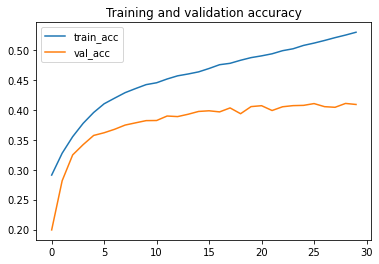

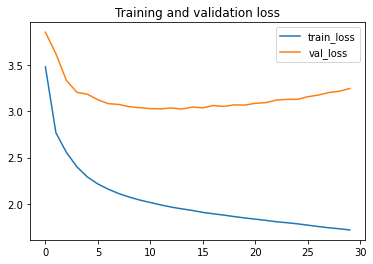

In [ ]:
plot_accuracy_loss(history)

In [ ]:
def Evaluation(model):
  results = model.evaluate([val_X_seqs_final,val_X_ims_final], val_Y_final, batch_size=300)
  print('val loss, val acc:', results)
Evaluation(model)

406/406 [==============================] - 11s 26ms/step - loss: 3.2440 - accuracy: 0.4090
val loss, val acc: [3.2440288066864014, 0.4090377986431122]


In [ ]:
model.save(BASE_PATH_parssoft+'model_30ep_all.h5')

In [ ]:
result = []

p = model.predict([val_X_seqs_final,val_X_ims_final],batch_size=64)

for q in range(len(val_q_ids)):
  ans=indextoanswer[p[q].argmax(axis=-1)]
  q_id=val_q_ids[q]
  result.append({u'answer': ans, u'question_id': q_id})

  # if q%50000==0 :print(q)

print('Saving result...')
my_list = list(result)
dd = json.dump(my_list,open(BASE_PATH_parssoft2+'result.json','w'))

In [ ]:
!git clone https://github.com/GT-Vision-Lab/VQA.git

Cloning into 'VQA'...
remote: Enumerating objects: 291, done.
remote: Total 291 (delta 0), reused 0 (delta 0), pack-reused 291
Receiving objects: 100% (291/291), 1.74 MiB | 4.03 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [ ]:
!git clone https://github.com/ntusteeian/VQA_evaluation.git

Cloning into 'VQA_evaluation'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 301 (delta 0), reused 5 (delta 0), pack-reused 291
Receiving objects: 100% (301/301), 1.75 MiB | 15.86 MiB/s, done.
Resolving deltas: 100% (124/124), done.


loading VQA annotations and questions into memory...
0:00:04.774469
creating index...
index created!
Loading and preparing results...     
DONE (t=0.33s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy


Overall Accuracy is: 47.37

Per Question Type Accuracy is the following:
what is the : 24.50
is the : 73.23
what : 26.13
is this an : 76.83
are there : 82.40
what is in the : 22.59
is it : 76.04
what is : 18.09
how many : 38.72
is this : 73.85
is there a : 89.55
is the person : 73.95
is this a : 74.67
what color is the : 39.01
how : 18.35
do : 75.02
how many people are in : 34.88
why : 13.43
are the : 73.77
none of the above : 45.70
are : 73.10
does this : 77.49
what is the person : 18.84
what are : 23.79
who is : 17.66
what brand : 31.16
has : 75.48
what kind of : 27.25
is the man : 77.35
are they : 75.43
what type of : 30.44
is : 77.24
is this person : 73.83
what is the man : 24.35
are these : 71.33
how many peop

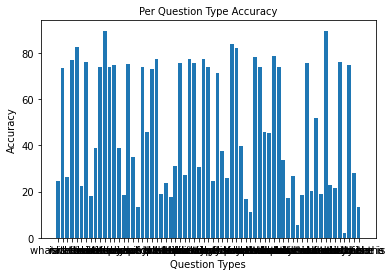

In [1]:
# coding: utf-8

import sys
dataDir = '/content/drive/My Drive/parssoftco_PVQA2'
sys.path.insert(0, '/content/drive/My Drive/parssoftco_PVQA/')
from vqaTools.vqa import VQA
from vqaEvaluation.vqaEval import VQAEval
import matplotlib.pyplot as plt
import skimage.io as io
import json
import random
import os

# set up file names and paths
versionType ='' # this should be '' when using VQA v2.0 dataset
taskType    ='OpenEnded' # 'OpenEnded' only for v2.0. 'OpenEnded' or 'MultipleChoice' for v1.0
dataType    ='mscoco'  # 'mscoco' only for v1.0. 'mscoco' for real and 'abstract_v002' for abstract for v1.0. 
dataSubType ='val2014'
annFile     ='%s/%s%s_%s_annotations.json'%(dataDir, versionType, dataType, dataSubType)
quesFile    ='%s/%s%s_%s_%s_questions.json'%(dataDir, versionType, taskType, dataType, dataSubType)
imgDir      ='%s/Images/%s/%s/' %(dataDir, dataType, dataSubType)
fileTypes   = ['results', 'accuracy', 'evalQA', 'evalQuesType', 'evalAnsType']

# An example result json file has been provided in './Results' folder.  

[resFile, accuracyFile, evalQAFile, evalQuesTypeFile, evalAnsTypeFile] =['%s/result.json'%(dataDir) for fileType in fileTypes]
# create vqa object and vqaRes object
vqa = VQA(annFile, quesFile)
vqaRes = vqa.loadRes(resFile, quesFile)

# create vqaEval object by taking vqa and vqaRes
vqaEval = VQAEval(vqa, vqaRes, n=2)   #n is precision of accuracy (number of places after decimal), default is 2

# evaluate results
"""
If you have a list of question ids on which you would like to evaluate your results, pass it as a list to below function
By default it uses all the question ids in annotation file
"""
vqaEval.evaluate() 

# print accuracies
print ("\n")
print ("Overall Accuracy is: %.02f\n" %(vqaEval.accuracy['overall']))
print ("Per Question Type Accuracy is the following:")
for quesType in vqaEval.accuracy['perQuestionType']:
	print ("%s : %.02f" %(quesType, vqaEval.accuracy['perQuestionType'][quesType]))
print ("\n")
print ("Per Answer Type Accuracy is the following:")
for ansType in vqaEval.accuracy['perAnswerType']:
	print ("%s : %.02f" %(ansType, vqaEval.accuracy['perAnswerType'][ansType]))
print ("\n")
# demo how to use evalQA to retrieve low score result
evals = [quesId for quesId in vqaEval.evalQA if vqaEval.evalQA[quesId]<35]   #35 is per question percentage accuracy
if len(evals) > 0:
	print ('ground truth answers')
	randomEval = random.choice(evals)
	randomAnn = vqa.loadQA(randomEval)
	vqa.showQA(randomAnn)

	print ('\n')
	print ('generated answer (accuracy %.02f)'%(vqaEval.evalQA[randomEval]))
	# ann = vqaRes.loadQA(randomEval)[0]
	# print ("Answer:   %s\n" %(ann['answer']))

	# imgId = randomAnn[0]['image_id']
	# imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
	# if os.path.isfile(imgDir + imgFilename):
	# 	I = io.imread(imgDir + imgFilename)
	# 	plt.imshow(I)
	# 	plt.axis('off')
	# 	plt.show()

# plot accuracy for various question types
plt.bar(range(len(vqaEval.accuracy['perQuestionType'])), vqaEval.accuracy['perQuestionType'].values(), align='center')
plt.xticks(range(len(vqaEval.accuracy['perQuestionType'])), vqaEval.accuracy['perQuestionType'].keys(), rotation='0',fontsize=10)
plt.title('Per Question Type Accuracy', fontsize=10)
plt.xlabel('Question Types', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.show()

# save evaluation results to ./Results folder
json.dump(vqaEval.accuracy,     open(accuracyFile,     'w'))
json.dump(vqaEval.evalQA,       open(evalQAFile,       'w'))
json.dump(vqaEval.evalQuesType, open(evalQuesTypeFile, 'w'))
# json.dump(vqaEval.evalAnsType,  open(evalAnsTypeFile,  'w'))

In [3]:
a=[1,2,3]
a[:2]

[1, 2]

In [ ]:
!python /content/drive/My\ Drive/parssoftco_PVQA/vqaEvalDemo.py

loading VQA annotations and questions into memory...
0:00:01.991607
creating index...
index created!
Loading and preparing results...     
Traceback (most recent call last):
  File "/content/drive/My Drive/parssoftco_PVQA/vqaEvalDemo.py", line 29, in <module>
    vqaRes = vqa.loadRes(resFile, quesFile)
  File "/content/drive/My Drive/parssoftco_PVQA/vqaTools/vqa.py", line 159, in loadRes
    assert type(anns) == list, 'results is not an array of objects'
AssertionError: results is not an array of objects


In [ ]:
from keras.models import load_model

model.save(BASE_PATH_parssoft+ 'model_alldata_30ep_eng_rmslrdecay.h5', overwrite=True)  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
# model = load_model('my_model.h5')


RuntimeError: ignored

In [ ]:
def plot_accuracy_loss(history):
  acc      = history.history[     'accuracy' ]
  val_acc  = history.history[ 'val_accuracy' ]
  loss     = history.history[    'loss' ]
  val_loss = history.history['val_loss' ]

  epochs   = range(len(acc))

  plt.plot  ( epochs,     acc, label='train_acc' )
  plt.plot  ( epochs, val_acc, label='val_acc' )
  plt.title ('Training and validation accuracy')
  plt.legend()
  plt.savefig(BASE_PATH + 'Training and validation accuracy.jpg')
  plt.figure()

  plt.plot  ( epochs,     loss, label='train_loss' )
  plt.plot  ( epochs, val_loss, label='val_loss' )
  plt.title ('Training and validation loss'   )
  plt.legend()
  plt.savefig(BASE_PATH + 'Training and validation loss.jpg')

### Evaluate

In [ ]:
# Download the VQA Questions from http://www.visualqa.org/download.html
import json
import os
import argparse


'''
Put the VQA data into single json file, where [[Question_id, Image_id, Question, multipleChoice_answer, Answer] ... ]
'''

train = []
test = []
imdir='%s/COCO_%s_%012d.jpg'


print('Loading annotations and questions...')
train_anno = json.load(open(ANNOTATION_TRAIN_PATH, 'r'))
val_anno = json.load(open(ANNOTATION_VAL_PATH, 'r'))

train_ques = json.load(open(QUESTION_TRAIN_PATH, 'r'))
val_ques = json.load(open(QUESTION_VAL_PATH, 'r'))

subtype = 'train2014'
for i in range(len(train_anno['annotations'])):
    ans = train_anno['annotations'][i]['multiple_choice_answer']
    question_id = train_anno['annotations'][i]['question_id']
    image_path = imdir%(subtype, subtype, train_anno['annotations'][i]['image_id'])

    question = train_ques['questions'][i]['question']
    mc_ans = train_ques['questions'][i]['question']

    train.append({'ques_id': question_id, 'img_path': image_path, 'question': question, 'MC_ans': mc_ans, 'ans': ans})

subtype = 'val2014'
for i in range(len(val_anno['annotations'])):
    ans = val_anno['annotations'][i]['multiple_choice_answer']
    question_id = val_anno['annotations'][i]['question_id']
    image_path = imdir%(subtype, subtype, val_anno['annotations'][i]['image_id'])

    question = val_ques['questions'][i]['question']
    mc_ans = val_ques['questions'][i]['question']

    test.append({'ques_id': question_id, 'img_path': image_path, 'question': question, 'MC_ans': mc_ans, 'ans': ans})


print('Training sample %d, Testing sample %d...' %(len(train), len(test)))

json.dump(train, open('vqa_raw_train.json', 'w'))
json.dump(test, open('vqa_raw_test.json', 'w'))


# !cp /content/vqa_raw_train.json /content/drive/My\ Drive/parssoftco_PVQA/vqa_raw_train.json
# !cp /content/vqa_raw_test.json /content/drive/My\ Drive/parssoftco_PVQA/vqa_raw_test.json


def get_top_answers(imgs, params):
  counts = {}
  for img in imgs:
    ans = img['ans']
    counts[ans] = counts.get(ans, 0) + 1
  cw = sorted([(count,w) for w,count in counts.items()], reverse=True)
  vocab = []
  for i in range(params):
      vocab.append(cw[i][1])
  return vocab[:params]


def filter_question(imgs, atoi):
    new_imgs = []
    for i, img in enumerate(imgs):
        if atoi.get(img['ans'],len(atoi)+1) != len(atoi)+1:
            new_imgs.append(img)

    print('question number reduce from %d to %d '%(len(imgs), len(new_imgs)))
    return new_imgs
imgs_train = json.load(open('vqa_raw_train.json', 'r'))
imgs_test = json.load(open('vqa_raw_test.json', 'r'))

# get top answers
top_ans = get_top_answers(imgs_train, 999)
atoi = {w:i+1 for i,w in enumerate(top_ans)}
itoa = {i+1:w for i,w in enumerate(top_ans)}

# filter question, which isn't in the top answers.
imgs_train = filter_question(imgs_train, atoi)

Loading annotations and questions...
Training sample 248349, Testing sample 121512...
question number reduce from 248349 to 215359 


In [ ]:
q = json.load(open('vqa_raw_train.json', 'r'))
print(q[0])

{'ques_id': 4870250, 'img_path': 'train2014/COCO_train2014_000000487025.jpg', 'question': 'What shape is the bench seat?', 'MC_ans': 'What shape is the bench seat?', 'ans': 'curved'}


In [ ]:
imgs_train[0]

{'MC_ans': 'Is there a shadow?',
 'ans': 'yes',
 'img_path': 'train2014/COCO_train2014_000000487025.jpg',
 'ques_id': 4870251,
 'question': 'Is there a shadow?'}

In [ ]:
imgs_train

In [ ]:
# img_data = h5py.File(data_img)
ques_data = h5py.File('data_prepro.h5')

# img_data = np.array(img_data['images_train'])

# NOTE should've consturcted one-hots using exhausitve list of answers, cause some answers may not be in dataset
# To temporarily rectify this, all those answer indices is set to 1 in validation set
train_y = to_categorical(ques_data['answers'])[:, :]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


In [ ]:
train_y.shape

(215359, 1000)

In [ ]:
e=[]
for s in ques_data['answers']:
  e.append(s)
set(e)

In [ ]:
e=[]
for s in ques_data['answers']:
  e.append(s)
set(e)

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185